Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score


loading the data

In [3]:
df=pd.read_csv('listings.csv')

In [4]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


Cannot see all the column names along with the data types it contains.

Lets see the percentage of nulls in each column

In [5]:
for i in df.columns:
    print(f"{i:<32}" +' %  Nulls: ' + f"{str(int((df[i].isnull().sum()/len(df))*100)) : >10}")

id                               %  Nulls:          0
listing_url                      %  Nulls:          0
scrape_id                        %  Nulls:          0
last_scraped                     %  Nulls:          0
name                             %  Nulls:          0
summary                          %  Nulls:          4
space                            %  Nulls:         14
description                      %  Nulls:          0
experiences_offered              %  Nulls:          0
neighborhood_overview            %  Nulls:         27
notes                            %  Nulls:         42
transit                          %  Nulls:         24
thumbnail_url                    %  Nulls:          8
medium_url                       %  Nulls:          8
picture_url                      %  Nulls:          0
xl_picture_url                   %  Nulls:          8
host_id                          %  Nulls:          0
host_url                         %  Nulls:          0
host_name                   

Many columns have data that provide no value and no value can be extracted through feature engineering.

Will do an initial drop and inspect the rest of the columns accordingly

In [6]:
df=df.drop(['listing_url','thumbnail_url','medium_url' , 'picture_url','xl_picture_url','scrape_id','last_scraped',
            'experiences_offered','picture_url','requires_license','license','jurisdiction_names','state','city','market'
            ,'smart_location','country_code','country','longitude','latitude','square_feet','has_availability',
            'calendar_last_scraped','host_url','host_name','host_location','host_about','host_thumbnail_url',
            'host_picture_url','street','availability_30','availability_60','availability_90','first_review',
            'last_review','minimum_nights','maximum_nights','extra_people'],axis=1)

Lets look at the data types

In [7]:
for i in df.columns:
    print(f"{i:<32}" +'  : '+ str(df[i].dtypes))

id                                : int64
name                              : object
summary                           : object
space                             : object
description                       : object
neighborhood_overview             : object
notes                             : object
transit                           : object
host_id                           : int64
host_since                        : object
host_response_time                : object
host_response_rate                : object
host_acceptance_rate              : object
host_is_superhost                 : object
host_neighbourhood                : object
host_listings_count               : float64
host_total_listings_count         : float64
host_verifications                : object
host_has_profile_pic              : object
host_identity_verified            : object
neighbourhood                     : object
neighbourhood_cleansed            : object
neighbourhood_group_cleansed      : object
zipcode    

Many numerical columns are formated as objects, will need to change them to float for easier exploration

In [8]:
def numeric_converter(df):
    for i in df.columns:
        df[i]=df[i].str.strip('% $ ,')
        df[i]=df[i].str.replace(',', '')
        df[i]=pd.to_numeric(df[i],downcast='float')
    return df

df[['host_response_rate','price','security_deposit','cleaning_fee']]=numeric_converter(df[['host_response_rate','price','security_deposit','cleaning_fee']])



<ipython-input-8-4f2d9ed253f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=df[i].str.strip('% $ ,')
<ipython-input-8-4f2d9ed253f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=df[i].str.replace(',', '')
<ipython-input-8-4f2d9ed253f3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Instead of dropping the below columns directly, will try to see if there's a correlation between a positive language and the unit price

The below columns have no sentiment as per definition, so will check if the more a person describes the unit the higher the demand and therefore the price

In [9]:
cols=['notes','transit']

In [10]:
for i in cols:
    df[i]=df[i].str.len()

In [11]:
df_sent1=df[['id','name','summary','space','description']]

Filling the nulls with a neutral word because the sentiment analyzer does not work with nulls

In [12]:
df.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,host_id,host_since,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,956883,2011-08-11,...,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",1000.0,162.0,5177328,2013-02-21,...,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,155.0,202.0,16708587,2014-06-12,...,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,NaN,9851441,2013-11-06,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,9.0,295.0,1452570,2011-11-29,...,10.0,10.0,9.0,9.0,f,strict,f,f,1,0.89


In [13]:
df_sent1=df_sent1.fillna('none')

Defining a function and using it to replace each of the columns defined above in (df_sent1) with their sentiment value

There seem to be no correlation between any of the above columns and price

In [14]:
#plt.scatter(x=analyzed_df['description'],y=df['price']);
#analyzed_df['description'].corr(df['price'])

C:\Users\ajax2\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-15-dda7179e2eb7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['review_scores_total']=df1['review_scores_rating']+df1['review_scores_accuracy']+df1['review_scores_cleanliness']+df1.review_scores_checkin


-0.020269655985929252

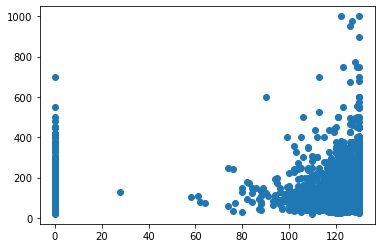

In [15]:
df1= df[['id', 'number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication','review_scores_value']]
df1.fillna(0,inplace=True)

df1['review_scores_total']=df1['review_scores_rating']+df1['review_scores_accuracy']+df1['review_scores_cleanliness']+df1.review_scores_checkin
+df1.review_scores_communication+df1.review_scores_value;

plt.scatter(x=df1['review_scores_total'],y=df['price']);
df1['review_scores_total'].corr(df['price'])

Drop the columns as they provide no value

In [16]:
df=df.drop(['name','summary','space','description','notes','transit','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication','review_scores_value','review_scores_location','neighborhood_overview'],axis=1)

Create a function that splits columns with multiple strings into separate columns and another function to count them

In [17]:
def str_split(df,col):
    
    df[col]=df[col].str.replace('"','')
    df[col]=df[col].str.strip(" []''")
    df=df[col].str.split(',',expand=True)
    
    return df

def row_count(df):    
    df['count']=df.apply(lambda x: x.count(), axis=1)
    return df

Use the above two functions on the Amenities column to check if there's a correlation between the number of amenities and price

In [18]:
df2=df[['amenities']]
df2['amenities']=row_count(str_split(df2,'amenities'))[:]['count']


df3=pd.concat([df['id'],df2],axis=1)

df['amenities']=df3['amenities']

<ipython-input-17-07fbf0b295e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col]=df[col].str.replace('"','')
<ipython-input-17-07fbf0b295e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col]=df[col].str.strip(" []''")
<ipython-input-18-746620fecf66>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

col_0,% observations
host_since,
2008-11-10,0.001048
2009-01-08,0.000262
2009-02-16,0.000524
2009-03-03,0.000262
2009-03-30,0.000262
...,...
2015-12-29,0.000262
2015-12-30,0.000262
2016-01-01,0.000262


# of unique values 1380


col_0,% observations
host_response_time,
a few days or more,0.011533
within a day,0.181184
within a few hours,0.293778
within an hour,0.513505


# of unique values 4


col_0,% observations
host_acceptance_rate,
0%,0.000328
100%,0.999672


# of unique values 2


col_0,% observations
host_is_superhost,
f,0.796122
t,0.203878


# of unique values 2


col_0,% observations
host_neighbourhood,
Alki,0.006254
Anaheim,0.001990
Arbor Heights,0.000853
Atlantic,0.013928
Baldwin Hills,0.000284
...,...
Wallingford,0.038090
Wedgewood,0.004548
Westlake,0.003411


# of unique values 102


col_0,% observations
host_verifications,
None,0.000524
"['email', 'facebook', 'google', 'linkedin', 'reviews', 'kba']",0.000262
"['email', 'facebook', 'reviews', 'jumio']",0.000786
"['email', 'facebook', 'reviews', 'kba']",0.000262
"['email', 'facebook', 'reviews']",0.000786
...,...
"['phone', 'reviews', 'kba']",0.000524
"['phone', 'reviews']",0.007858
['phone'],0.005238


# of unique values 116


col_0,% observations
host_has_profile_pic,
f,0.001834
t,0.998166


# of unique values 2


col_0,% observations
host_identity_verified,
f,0.214623
t,0.785377


# of unique values 2


col_0,% observations
neighbourhood,
Alki,0.006761
Arbor Heights,0.000882
Atlantic,0.014697
Ballard,0.062610
Belltown,0.059965
...,...
Wallingford,0.042034
Wedgewood,0.004409
Westlake,0.003527


# of unique values 81


col_0,% observations
neighbourhood_cleansed,
Adams,0.018334
Alki,0.011001
Arbor Heights,0.001310
Atlantic,0.013882
Belltown,0.061289
...,...
West Woodland,0.016763
Westlake,0.004453
Whittier Heights,0.006810


# of unique values 87


col_0,% observations
neighbourhood_group_cleansed,
Ballard,0.060241
Beacon Hill,0.030906
Capitol Hill,0.148507
Cascade,0.023311
Central Area,0.096647
Delridge,0.020691
Downtown,0.138816
Interbay,0.002881
Lake City,0.017548


# of unique values 17


col_0,% observations
zipcode,
98101,0.052742
98102,0.088953
98103,0.103385
98104,0.024928
98105,0.059040
98106,0.015219
98107,0.047232
98108,0.014694
98109,0.053004


# of unique values 28


col_0,% observations
is_location_exact,
f,0.106338
t,0.893662


# of unique values 2


col_0,% observations
property_type,
Apartment,0.447472
Bed & Breakfast,0.009693
Boat,0.002096
Bungalow,0.003406
Cabin,0.005502
Camper/RV,0.003406
Chalet,0.000524
Condominium,0.023841
Dorm,0.000524


# of unique values 16


col_0,% observations
room_type,
Entire home/apt,0.665532
Private room,0.303824
Shared room,0.030644


# of unique values 3


col_0,% observations
bed_type,
Airbed,0.007072
Couch,0.003405
Futon,0.019382
Pull-out Sofa,0.012310
Real Bed,0.957831


# of unique values 5


col_0,% observations
weekly_price,
"$1,000.00",0.034843
"$1,005.00",0.000498
"$1,008.00",0.001493
"$1,009.00",0.000498
"$1,015.00",0.000498
...,...
$985.00,0.000498
$990.00,0.002987
$993.00,0.000498


# of unique values 395


col_0,% observations
monthly_price,
"$1,000.00",0.011206
"$1,005.00",0.000659
"$1,020.00",0.000659
"$1,029.00",0.001318
"$1,050.00",0.003296
...,...
$975.00,0.000659
$985.00,0.001318
$987.00,0.000659


# of unique values 356


col_0,% observations
calendar_updated,
1 week ago,0.006810
10 months ago,0.002095
11 months ago,0.001310
12 months ago,0.001310
13 months ago,0.000524
14 months ago,0.000262
15 months ago,0.000262
16 months ago,0.000262
17 months ago,0.000262


# of unique values 34


col_0,% observations
instant_bookable,
f,0.845207
t,0.154793


# of unique values 2


col_0,% observations
cancellation_policy,
flexible,0.301205
moderate,0.327658
strict,0.371137


# of unique values 3


col_0,% observations
require_guest_profile_picture,
f,0.915925
t,0.084075


# of unique values 2


col_0,% observations
require_guest_phone_verification,
f,0.901781
t,0.098219


# of unique values 2


,id,host_id,host_response_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,availability_365,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3295.000000,3816.000000,3816.000000,3818.000000,3802.000000,3812.000000,3817.000000,3818.000000,3818.000000,1866.000000,2788.000000,3818.000000,3818.000000,3818.000000,3191.000000
mean,5.550111e+06,1.578556e+07,94.886795,7.157757,7.157757,3.349398,1.259469,1.307712,1.735394,14.370613,127.976166,287.610382,61.710903,1.672603,244.772656,2.946307,2.078919
std,2.962660e+06,1.458382e+07,11.866883,28.628149,28.628149,1.977599,0.590369,0.883395,1.139480,4.706825,90.250107,270.222626,48.830311,1.311040,126.772526,5.893029,1.822348
min,3.335000e+03,4.193000e+03,17.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,20.000000,95.000000,5.000000,0.000000,0.000000,1.000000,0.020000
25%,3.258256e+06,3.275204e+06,98.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,11.000000,75.000000,150.000000,25.000000,1.000000,124.000000,1.000000,0.695000
50%,6.118244e+06,1.055814e+07,100.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,14.000000,100.000000,250.000000,50.000000,1.000000,308.000000,1.000000,1.540000
75%,8.035127e+06,2.590309e+07,100.000000,3.000000,3.000000,4.000000,1.000000,2.000000,2.000000,17.000000,150.000000,300.000000,83.000000,2.000000,360.000000,2.000000,3.000000
max,1.034016e+07,5.320861e+07,100.000000,502.000000,502.000000,16.000000,8.000000,7.000000,15.000000,30.000000,1000.000000,5000.000000,300.000000,15.000000,365.000000,37.000000,12.150000


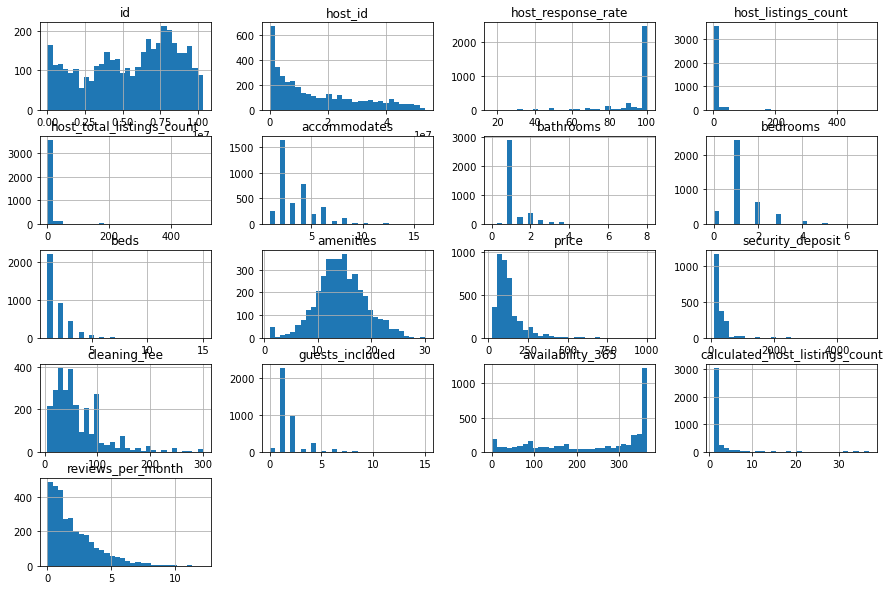

In [19]:
for column in df.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=df[column],
                        columns='% observations', 
                        normalize='columns'))
    print("# of unique values {}".format(df[column].nunique()))

# show summary statistics
display(df.describe())

# build histograms for each numeric feature
%matplotlib inline
hist = df.hist(bins=30, sharey=False, figsize=(15, 10))

In [20]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'calendar_updated', 'availability_365',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

In [21]:
host_ver_df=df[['host_verifications']]

In [22]:
df_dummies=df[['host_response_time','host_is_superhost','host_identity_verified','neighbourhood_group_cleansed','zipcode',
      'is_location_exact','property_type','room_type','bed_type','instant_bookable','cancellation_policy',
       'require_guest_profile_picture','require_guest_phone_verification']]

In [23]:
df=df.drop(['host_since','host_acceptance_rate','host_neighbourhood','host_has_profile_pic','neighbourhood_cleansed',
      'neighbourhood','weekly_price','monthly_price','calendar_updated'],axis=1)

In [24]:
df_numeric=df.select_dtypes(include=['int64','float64','float32','int32'])

df_numeric

,id,host_id,host_response_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,availability_365,calculated_host_listings_count,reviews_per_month
0,241032,956883,96.0,3.0,3.0,4,1.0,1.0,1.0,10,85.0,NaN,NaN,2,346,2,4.07
1,953595,5177328,98.0,6.0,6.0,4,1.0,1.0,1.0,16,150.0,100.0,40.0,1,291,6,1.48
2,3308979,16708587,67.0,2.0,2.0,11,4.5,5.0,7.0,21,975.0,1000.0,300.0,10,220,2,1.15
3,7421966,9851441,NaN,1.0,1.0,3,1.0,0.0,2.0,14,100.0,NaN,NaN,1,143,1,NaN
4,278830,1452570,100.0,2.0,2.0,6,2.0,3.0,3.0,13,450.0,700.0,125.0,6,365,1,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,31148752,99.0,354.0,354.0,6,2.0,3.0,3.0,16,359.0,NaN,230.0,1,32,8,0.30
3814,8902327,46566046,100.0,1.0,1.0,4,1.0,1.0,2.0,17,79.0,500.0,50.0,3,273,1,2.00
3815,10267360,52791370,NaN,1.0,1.0,2,1.0,1.0,1.0,20,93.0,250.0,35.0,2,88,1,NaN
3816,9604740,25522052,100.0,1.0,1.0,2,1.0,0.0,1.0,11,99.0,300.0,45.0,1,179,1,NaN


In [25]:
df.shape[1]-df_dummies.shape[1]-df_numeric.shape[1]

1

In [26]:
df_dummies

,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_group_cleansed,zipcode,is_location_exact,property_type,room_type,bed_type,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,within a few hours,f,t,Queen Anne,98119,t,Apartment,Entire home/apt,Real Bed,f,moderate,f,f
1,within an hour,t,t,Queen Anne,98119,t,Apartment,Entire home/apt,Real Bed,f,strict,t,t
2,within a few hours,f,t,Queen Anne,98119,t,House,Entire home/apt,Real Bed,f,strict,f,f
3,NaN,f,t,Queen Anne,98119,t,Apartment,Entire home/apt,Real Bed,f,flexible,f,f
4,within an hour,f,t,Queen Anne,98119,t,House,Entire home/apt,Real Bed,f,strict,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,within a few hours,f,t,Other neighborhoods,98107,t,House,Entire home/apt,Real Bed,f,strict,f,f
3814,within an hour,f,t,Capitol Hill,98102,t,Apartment,Entire home/apt,Real Bed,f,moderate,f,f
3815,NaN,f,f,Rainier Valley,98178,f,House,Entire home/apt,Real Bed,f,moderate,f,f
3816,within an hour,f,t,Capitol Hill,98112,f,Condominium,Entire home/apt,Real Bed,f,moderate,f,f


In [27]:
df['host_verifications']=row_count(str_split(host_ver_df,'host_verifications'))[:]['count']

In [28]:
df.head()

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,neighbourhood_group_cleansed,...,security_deposit,cleaning_fee,guests_included,availability_365,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,956883,within a few hours,96.0,f,3.0,3.0,4,t,Queen Anne,...,NaN,NaN,2,346,f,moderate,f,f,2,4.07
1,953595,5177328,within an hour,98.0,t,6.0,6.0,6,t,Queen Anne,...,100.0,40.0,1,291,f,strict,t,t,6,1.48
2,3308979,16708587,within a few hours,67.0,f,2.0,2.0,5,t,Queen Anne,...,1000.0,300.0,10,220,f,strict,f,f,2,1.15
3,7421966,9851441,NaN,NaN,f,1.0,1.0,5,t,Queen Anne,...,NaN,NaN,1,143,f,flexible,f,f,1,NaN
4,278830,1452570,within an hour,100.0,f,2.0,2.0,5,t,Queen Anne,...,700.0,125.0,6,365,f,strict,f,f,1,0.89


In [29]:
for i in df.columns:
    print(f"{i:<32}" +'  : '+ str(df[i].dtypes))

id                                : int64
host_id                           : int64
host_response_time                : object
host_response_rate                : float32
host_is_superhost                 : object
host_listings_count               : float64
host_total_listings_count         : float64
host_verifications                : int64
host_identity_verified            : object
neighbourhood_group_cleansed      : object
zipcode                           : object
is_location_exact                 : object
property_type                     : object
room_type                         : object
accommodates                      : int64
bathrooms                         : float64
bedrooms                          : float64
beds                              : float64
bed_type                          : object
amenities                         : int64
price                             : float32
security_deposit                  : float32
cleaning_fee                      : float32
guests_

In [30]:
df_dummies=pd.get_dummies(df_dummies,dummy_na=True)

In [31]:
for i in df_dummies.columns:
    print(f"{i:<32}" +'  : '+ str(df_dummies[i].dtypes))

host_response_time_a few days or more  : uint8
host_response_time_within a day   : uint8
host_response_time_within a few hours  : uint8
host_response_time_within an hour  : uint8
host_response_time_nan            : uint8
host_is_superhost_f               : uint8
host_is_superhost_t               : uint8
host_is_superhost_nan             : uint8
host_identity_verified_f          : uint8
host_identity_verified_t          : uint8
host_identity_verified_nan        : uint8
neighbourhood_group_cleansed_Ballard  : uint8
neighbourhood_group_cleansed_Beacon Hill  : uint8
neighbourhood_group_cleansed_Capitol Hill  : uint8
neighbourhood_group_cleansed_Cascade  : uint8
neighbourhood_group_cleansed_Central Area  : uint8
neighbourhood_group_cleansed_Delridge  : uint8
neighbourhood_group_cleansed_Downtown  : uint8
neighbourhood_group_cleansed_Interbay  : uint8
neighbourhood_group_cleansed_Lake City  : uint8
neighbourhood_group_cleansed_Magnolia  : uint8
neighbourhood_group_cleansed_Northgate  : uint8

<AxesSubplot:>

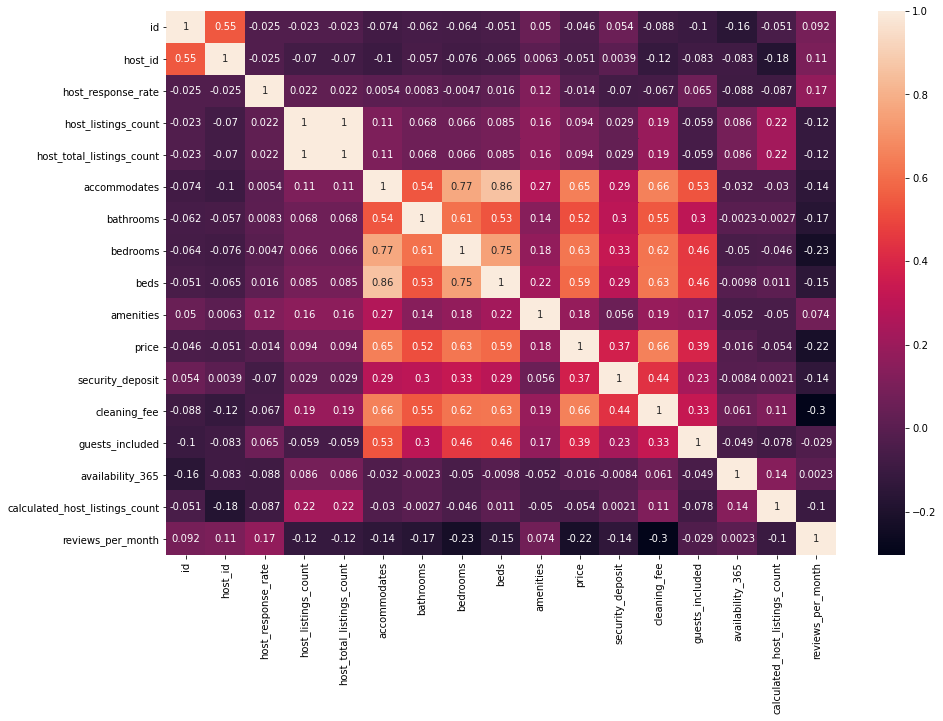

In [32]:
plt.figure(figsize = (15, 10))
sns.heatmap(df_numeric.corr(), annot=True)

In [37]:
df_numeric=df_numeric.drop(['id','host_id','availability_365', 'host_response_rate','host_listings_count','host_total_listings_count','calculated_host_listings_count','reviews_per_month'],axis=1)

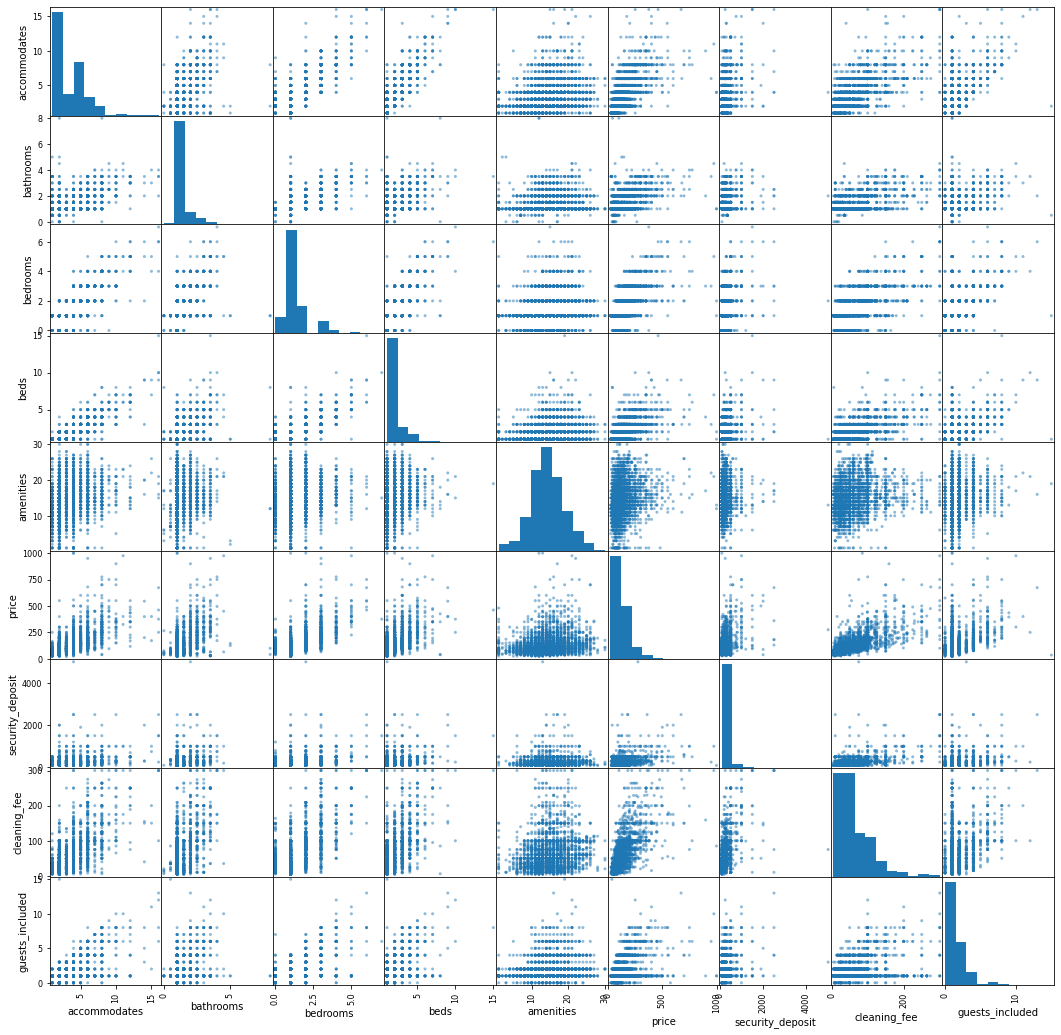

In [38]:
pd.plotting.scatter_matrix(df_numeric, figsize=(18,18));

In [ ]:
df_numeric=df_numeric.drop(['beds','bathrooms'],axis=1)

In [ ]:
plt.figure(figsize = (15, 10))
sns.heatmap(df_numeric.corr(), annot=True)

In [39]:
y=df_numeric['price']
df_numeric=df_numeric.drop(['price'],axis=1)

In [ ]:
def normalize(df):
    for i in df.columns:
        df[i]=StandardScaler().fit_transform(df[[i]])[:,0]
    return df
df_numeric=normalize(df_numeric)

In [40]:
df_model=pd.concat([df_numeric,df_dummies],axis=1)

In [41]:
df_model.fillna( df_model.median() ,inplace=True)

In [42]:
X=df_model

In [43]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [145]:
lr=LinearRegression()

In [146]:
lr.fit(X_train,y_train)

LinearRegression()

In [147]:
y_pred=lr.predict(X_test)

In [148]:
r2_score(y_test,y_pred)

0.6041945272336156

In [136]:
RF=RandomForestRegressor(n_estimators=200 , oob_score = True, n_jobs = -1,
                                  random_state =42, max_features = "auto",
                                  max_leaf_nodes = 400)

In [137]:
RF.fit(X_train,y_train)

RandomForestRegressor(max_leaf_nodes=400, n_estimators=200, n_jobs=-1,
                      oob_score=True, random_state=42)

In [138]:
y_pred_RF=RF.predict(X_test)

In [139]:
r2_score(y_test,y_pred_RF)

0.6170941112242889

In [140]:
lr.get_params(deep=True)

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}